# Распознавание объектов на изображениях из набора данных CIFAR-10

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

Учебный курс "[Программирование глубоких нейронных сетей на Python](https://openedu.ru/course/urfu/PYDNN/)".

<a target="_blank" href="https://colab.research.google.com/github/sozykin/dlpython_course/blob/master/cnn/pytorch/cifar10.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Загружаем набор данных

Определяем инструмент предварительной обработки изображений из набора данных

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

Загружаем наборы данных для обучения и тестирования

In [3]:
trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)


100.0%


Создаем загрузчики данных

In [6]:
# Размер мини-выборки
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False)

Имена классов

In [7]:
classes = ('самолет', 'машина', 'птица', 'кот',
           'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

Просматриваем примеры изображений



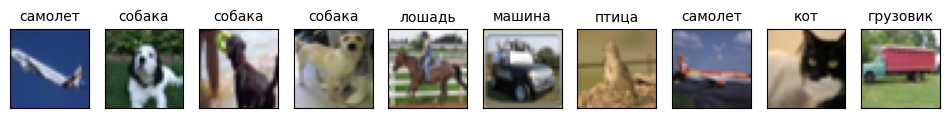

In [8]:
nsamples=10

imgs, labels = next(iter(trainloader))

fig=plt.figure(figsize=(12,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    img = imgs[i] / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(classes[labels[i]], fontsize=10)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Создаем модель




In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [10]:
device

'cuda'

Описываем класс для модели

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

Создаем модель на основе описанного класса

In [30]:
model = NeuralNetwork().to(device)


In [31]:
model

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Обучаем модель

Задаем функцию ошибки - категориальная перекрестная энтропия



In [32]:
loss_fn = nn.CrossEntropyLoss()

Задаем оптимизатор

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Определяем функцию для обучения нейронной сети



In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Включаем режим обучения
    model.train()
    # В цикле получаем все мини-выборки
    # X - изображение
    # y - номер класса
    for batch, (X, y) in enumerate(dataloader):
        # Передаем данные на устройство
        X, y = X.to(device), y.to(device)
        # Обнуляем значения градиента
        optimizer.zero_grad()

        # Расчитываем данные на выходе из нейронной сети
        pred = model(X)

        # Расчитываем значение ошибки
        loss = loss_fn(pred, y)

        # Обратное распространение ошибки
        loss.backward()

        # Выполняем шаг обучения (изменение весов)
        optimizer.step()

        # Печатаем прогресс каждые 50 мини-выборок
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Ошибка: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Определяем функцию для проверки качества работы нейронной сети на тестовом наборе данных

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Включаем режим оценки качества модели
    model.eval()
    # Начальные значения
    test_loss, correct = 0, 0
    # Для оценки качества работы не нужно рассчитывать градиент
    with torch.no_grad():
        # В цикле проходим по мини-выборкам из тестового набора данных
        for X, y in dataloader:
            # Передаем данные на устройство
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Качество на тестовом наборе данных: \n Доля правильных ответов: {(100*correct):>0.1f}%, средняя ошибка: {test_loss:>8f} \n")

Обучаем модель в течение 10 эпох



In [36]:
epochs = 10
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Обучение модели
    train(trainloader, model, loss_fn, optimizer)
    # Оценка качества работы на тестовом объеме данных
    test(testloader, model, loss_fn)
print("Обучение завершено!")

Эпоха 1
-------------------------------
Ошибка: 2.303208  [  256/50000]
Ошибка: 1.317675  [25856/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 58.3%, средняя ошибка: 1.159195 

Эпоха 2
-------------------------------
Ошибка: 1.219925  [  256/50000]
Ошибка: 1.016839  [25856/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 63.4%, средняя ошибка: 1.036520 

Эпоха 3
-------------------------------
Ошибка: 0.862405  [  256/50000]
Ошибка: 0.825003  [25856/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 68.5%, средняя ошибка: 0.893645 

Эпоха 4
-------------------------------
Ошибка: 0.601771  [  256/50000]
Ошибка: 0.652593  [25856/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 70.3%, средняя ошибка: 0.854531 

Эпоха 5
-------------------------------
Ошибка: 0.551751  [  256/50000]
Ошибка: 0.577492  [25856/50000]
Качество на тестовом наборе данных: 
 Доля правильных ответов: 72.3%, средняя ошибка: 0.8709

## Сохранение обученной модели



Параметры модели

In [37]:
model.state_dict()

OrderedDict([('network.0.weight',
              tensor([[[[-7.3827e-02,  7.7570e-02,  2.7573e-01],
                        [-2.1690e-01, -1.0436e-01,  3.9126e-02],
                        [-3.0117e-02, -2.1784e-01, -1.0141e-01]],
              
                       [[ 1.8187e-01,  1.6912e-01,  3.0831e-01],
                        [-6.2372e-02, -1.8346e-01,  7.8420e-02],
                        [-1.5910e-01, -1.7552e-01, -7.3945e-02]],
              
                       [[-1.2076e-01,  1.8069e-02, -2.8633e-02],
                        [-1.6349e-01,  4.2020e-02, -9.9389e-02],
                        [-5.8765e-02,  7.2658e-03,  1.7991e-02]]],
              
              
                      [[[-4.3415e-02,  1.5269e-01, -2.2901e-01],
                        [-2.1949e-01,  9.0579e-02,  1.6540e-01],
                        [ 5.8103e-02,  1.1048e-02,  3.7311e-02]],
              
                       [[-5.5297e-02,  1.6335e-01,  4.5088e-02],
                        [-1.4166e-01,  3.

In [38]:
torch.save(model.state_dict(), "model.pth")

## Загрузка модели



In [39]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

## Распознавание изображений из тестового набора данных



In [40]:
model.eval()

NeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [43]:
x, y = testset[5]

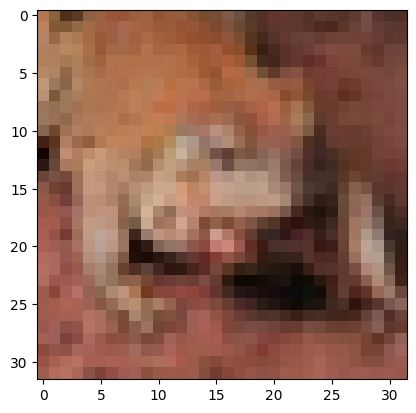

In [44]:
img = x / 2 + 0.5
plt.imshow(img.permute(1, 2, 0))

Запускаем распознавание

In [45]:
with torch.no_grad():
    x = x.unsqueeze(0).to(device)
    pred = model(x)

Результаты распознавания

In [46]:
pred

tensor([[ -8.5583,  -8.1837,  -2.7455,  -4.2289,  -5.9160,  -3.2598,  10.6562,
         -10.0503, -10.5213,  -3.8389]], device='cuda:0')

Номер класса

In [47]:
pred[0].argmax(0)

tensor(6, device='cuda:0')

Название класса

In [48]:
classes[pred[0].argmax(0)]

'лягушка'

Правильный ответ

In [49]:
y

6

In [50]:
classes[y]

'лягушка'

## Распознаем дополнительное изображение

In [51]:
from PIL import Image

In [63]:
img = Image.open("../frog.jpg")

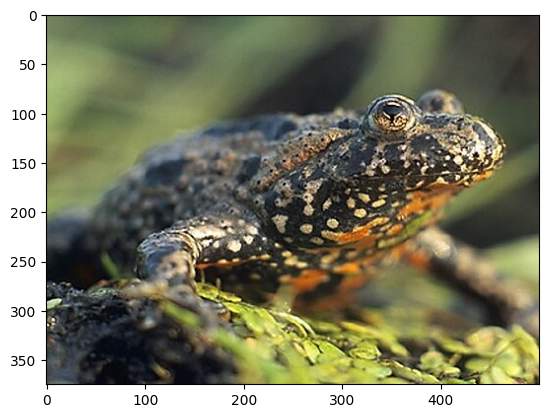

In [64]:
plt.imshow(img)

## Выполняем предварительную обработку изображения

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ])

In [66]:
batch = transform(img).unsqueeze(0)

In [67]:
batch

tensor([[[[0.4471, 0.4196, 0.3765,  ..., 0.2510, 0.2196, 0.2118],
          [0.4510, 0.4235, 0.4039,  ..., 0.2510, 0.2353, 0.2314],
          [0.5098, 0.4784, 0.4549,  ..., 0.2549, 0.2588, 0.2471],
          ...,
          [0.2784, 0.2314, 0.1608,  ..., 0.7412, 0.7608, 0.7765],
          [0.2941, 0.2510, 0.1490,  ..., 0.7882, 0.8078, 0.7412],
          [0.2902, 0.2549, 0.1765,  ..., 0.8706, 0.7608, 0.6275]],

         [[0.4980, 0.4706, 0.4353,  ..., 0.2392, 0.2078, 0.2039],
          [0.5137, 0.4863, 0.4667,  ..., 0.2392, 0.2196, 0.2118],
          [0.5804, 0.5451, 0.5255,  ..., 0.2510, 0.2392, 0.2196],
          ...,
          [0.2980, 0.2588, 0.1843,  ..., 0.7529, 0.7569, 0.7529],
          [0.3137, 0.2745, 0.1569,  ..., 0.8157, 0.8196, 0.7216],
          [0.3255, 0.2980, 0.1922,  ..., 0.8784, 0.7333, 0.5922]],

         [[0.3686, 0.3490, 0.3255,  ..., 0.2157, 0.1882, 0.1882],
          [0.3647, 0.3451, 0.3333,  ..., 0.2078, 0.1922, 0.1922],
          [0.4039, 0.3765, 0.3647,  ..., 0

## Выполняем классификацию изображения

Выполняем распознавание

In [68]:
batch = batch.to(device)

In [69]:
prediction = model(batch).squeeze(0)

Результаты распознавания

In [70]:
prediction

tensor([-0.2783, -4.8063, -2.7685, -0.0311, -1.2850, -2.6228, -0.5674, -2.9175,
        -3.2299, -1.9130], device='cuda:0', grad_fn=<SqueezeBackward1>)

Выбираем класс с максимальной вероятностью

In [71]:
class_id = prediction.argmax().item()

In [72]:
class_id

3

Название класса

In [73]:
classes[class_id]

'кот'